<a href="https://colab.research.google.com/github/hongqin/deep_learning_DNA/blob/master/learnseq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this tutorial, we'll walk through running a neural network on genome data.

This part won't be very iPython tutorial-ly...

First cd in the terminal over to the data directory and have a look to our data.

In [2]:
! ls

humanvsran  humanvsran_label  predict_seq.py  sample_data


Here you will find four files:<br><font color="#417EAE">humanvsran</font>: contain human 10,000 human sequences and 10,000 random sequences generated by RSAT random-seq.<br><font color="#417EAE">humanvsran_label</font>: labels for <font color="#417EAE">humanvsran</font>, where 1 stands for human sequences and 0 stands for random sequences.<br><font color="#417EAE">predict_seq.py</font>: python code for our CNN.<br><font color="#417EAE">learnseq.ipynb</font>: that's me!



Now lets have a look to our data!

In [3]:
!head humanvsran -n 3

CTACTCGGGAGGCTGAGGCAGGAGAATCACTTGAACCAGGGAGTCAGAGGTTGCAGTGAGCCAAGATCGCACCACTGCACTCCAGCCTGGCAACACAGCGAGAGTCTGTCTCCAAAAAAAAAAAAAAAGGCCCAAGAGCATTTCAAACTGTTTGTTGAGAGGTAATCTTATACATTCAGTTTCTTTTGGCTTACCTGAAGAGGTGCTTGGCTATGGTTAACAAACTACGTAAGCTGGTGAAAAAACCTGT
CACCTTATCCAGAGAAGCTTCTTCTTTTAGAAAATCAAGCAAAACAACTAAGCCAAGACATGTTAAAAAAAAAGTTTGAAAAGAAAGCTGTAAGGAAATACAAGGGGAGGGATTGTTAGATATGAGTTCTAAATTTCTTTTCAAAAAATCGATATGTCAGTATGTTCAATTCTTTGCCTTCTACTTTTAAACTTCCTCATAAAGCAACCTTTTTCAATTACCTGCTCCACCCTGACTCATTCTGATCACC
AAAGGGGCTGATAGAAAAATAAAGAGATTTGGCCAGGTACGGTGGCTCACTCCTGTAATCCCAGCACTTTGGGAGGCCGAGGCTGGCGGATCACCTGAGGTCGGGAGTTCGAGACCAGCCTGACCAACATGGAGAACCCCTGTCTCTACTAAAATTACAAAATTAGCCAGGCATGGTGGCACATGTCTGTAATCCCAGCTACTTGGGAGGCTGAGGCAGGAGGATCATTTGAACCAGGGAGGCAGAGGTT


These are sequences randomly cut from human chromosome 1. Now have a look to the label file also.

In [5]:
!tail humanvsran_label -n3

0
0
0


All 1s since they are all human sequence, so if you 'tail' the file, it will be all zeros!

Now lets begin to train our predict_seq program! First import some libraries.

In [16]:
import numpy as np
import os
import tensorflow as tf
import sys
import re
import random
#from tensorflow import keras
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [17]:
#========================= Model ==============================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD

Read our sequence and label file.

In [19]:
##Read data
f = open('humanvsran_label', "r")
lines = f.readlines()
f.close()
dat_y = np.zeros((len(lines),2))
for i in range(len(lines)):
	#dat_y[i] = float(dat_y[i].rstrip())
	dat_y[i,int(lines[i].rstrip())] = 1

f = open('humanvsran', "r")
lines = f.readlines()
f.close()

#Convert sequences into one-hot matrix
def DNA_matrix(seq):
	tem2 = ['[aA]','[cC]','[gG]','[tT]']
	for i in range(len(tem2)):
		ind = [m.start() for m in re.finditer(tem2[i], seq)]
		tem = np.zeros(len(seq),dtype=np.int)
		tem[ind] = 1
		if i==0:
			a = np.zeros((len(seq),4))
		a[...,i] = tem
	return a

for i in range(len(lines)):
	tem = lines[i].rstrip()
	if i==0:
		dat_x = np.zeros((len(lines),len(tem),4))
	dat_x[i,] = DNA_matrix(tem)


ind = range(20000)
random.shuffle(list(ind))
x_train=dat_x[ind[0:12000]]
y_train=dat_y[ind[0:12000]]
x_val=dat_x[ind[12001:14001]]
y_val=dat_y[ind[12001:14001]]
x_test=dat_x[14001:20001]
y_test=dat_y[14001:20001]
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


And you're good to go! Start training!

In [20]:
model=Sequential()
model.add(Conv1D(filters=20,kernel_size=10,strides=1,padding='valid',input_shape=(250,4), activation='relu'))
model.add(MaxPooling1D(pool_size=10, strides=5, padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='loss', patience=2, mode='min')
history = model.fit(x_train, y_train, batch_size=16, epochs=3, verbose=1, validation_data= None,callbacks=[early_stopping])
print(history.history)

Epoch 1/3
750/750 [==============================] - 6s 7ms/step - loss: 0.2212 - accuracy: 0.9014
Epoch 2/3
750/750 [==============================] - 5s 7ms/step - loss: 0.0518 - accuracy: 0.9834
Epoch 3/3
750/750 [==============================] - 5s 6ms/step - loss: 0.0328 - accuracy: 0.9898
{'loss': [0.22122949361801147, 0.05178035423159599, 0.03281807154417038], 'accuracy': [0.9014166593551636, 0.9834166765213013, 0.9897500276565552]}


Next, evaluate our model

In [ ]:
y_score = model.predict(x_test)
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))


Testing loss: 0.0413593569079, acc: 0.988164694116



We can retrive and examine the weight matrix, and convert it into a PWM matrix.

In [ ]:
weights = model.layers[0].get_weights()
wt=(np.transpose(weights[0][:,:,0]))
wtm=np.transpose(weights[0][:,:,0]).min(axis=0)
wtp=wt-wtm
wtps=np.sum(wtp, axis=0)
print np.round((wtp/wtps)*100)

[[ 54.  31.  31.  35.  43.  16.  39.   0.  23.   7.]
 [ 18.   0.   0.  59.   0.   0.   0.  44.  31.  28.]
 [  0.  23.  35.   6.  10.  55.  13.  21.   0.   0.]
 [ 28.  45.  34.   0.  47.  29.  48.  34.  46.  65.]]


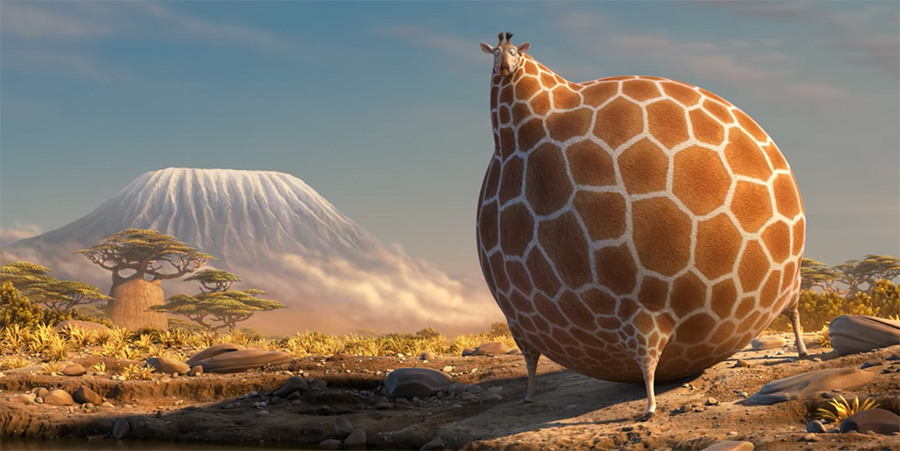

In [ ]:
from IPython.display import Image
Image(filename='../bonnie/rollin-wild-giraffe-klonblog.jpg')